In [2]:
%autosave 0

Autosave disabled


In [3]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape, cal_score_smooth

In [4]:
stack_idx = '16'
models = '1-27'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = True
add_intercept = True

### Read CV predictions and test

In [5]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [6]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [7]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [8]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [9]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [10]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [11]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
27
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-11-rf-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-23-lgb-binary-cv.csv
model-24-lgb-binary-augment-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.000

In [12]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [13]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,log_parea_pred_3,pred_4,log_pred_4,log_parea_pred_4,pred_5,log_pred_5,log_parea_pred_5,pred_6,log_pred_6,log_parea_pred_6,pred_7,log_pred_7,log_parea_pred_7,pred_8,log_pred_8,log_parea_pred_8,pred_9,log_pred_9,log_parea_pred_9,pred_10,log_pred_10,log_parea_pred_10,pred_11,log_pred_11,log_parea_pred_11,pred_12,log_pred_12,log_parea_pred_12,pred_13,log_pred_13,log_parea_pred_13,pred_14,log_pred_14,log_parea_pred_14,pred_15,log_pred_15,log_parea_pred_15,pred_16,log_pred_16,log_parea_pred_16,pred_17,log_pred_17,log_parea_pred_17,pred_18,log_pred_18,log_parea_pred_18,pred_19,log_pred_19,log_parea_pred_19,pred_20,log_pred_20,log_parea_pred_20,pred_21,log_pred_21,log_parea_pred_21,pred_22,log_pred_22,log_parea_pred_22,pred_23,log_pred_23,log_parea_pred_23,pred_24,log_pred_24,log_parea_pred_24,pred_25,log_pred_25,log_parea_pred_25,pred_26,log_pred_26,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,13.408579,12.179476,6.785936e+05,13.427779,12.198676,7.243271e+05,13.493000,12.263896,6.439099e+05,13.375316,12.146212,517457.72,13.156685,11.927583,725253.9,13.494278,12.265175,6.537177e+05,13.390432,12.161329,6.666997e+05,13.410097,12.180993,1.032484e+06,13.847480,12.618375,684619.56,13.436620,12.207517,633171.2,13.358498,12.129395,6.694336e+05,13.414189,12.185085,6.675904e+05,13.411432,12.182328,6.542462e+05,13.391241,12.162137,6.552449e+05,13.392766,12.163663,6.631879e+05,13.404815,12.175712,6.441883e+05,13.375748,12.146645,6.385893e+05,13.367018,12.137915,6.959114e+05,13.452979,12.223876,6.949261e+05,13.451562,12.222459,6.638564e+05,13.405823,12.176719,6.305493e+05,13.354348,12.125245,6.396151e+05,13.368623,12.139520,6.452832e+05,13.377446,12.148343,6.477905e+05,13.381324,12.152221,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,14.940179,13.543612,3.287974e+06,15.005782,13.609215,3.086645e+06,14.942596,13.546028,3.102187e+06,14.947618,13.551051,3384919.50,15.034841,13.638273,2841281.8,14.859766,13.463199,3.108813e+06,14.949752,13.553184,3.161088e+06,14.966427,13.569860,3.156863e+06,14.965090,13.568522,2999352.20,14.913907,13.517340,3101206.5,14.947302,13.550734,3.145496e+06,14.961483,13.564915,3.153173e+06,14.963920,13.567353,3.128284e+06,14.955995,13.559428,3.130186e+06,14.956603,13.560036,3.092403e+06,14.944459,13.547892,3.181958e+06,14.973008,13.576440,3.171011e+06,14.969561,13.572994,3.125225e+06,14.955017,13.558450,3.130663e+06,14.956756,13.560188,3.240645e+06,14.991283,13.594716,3.058136e+06,14.933317,13.536749,3.156574e+06,14.964998,13.568430,3.164660e+06,14.967557,13.570989,3.127411e+06,14.955716,13.559149,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,16.099407,14.379453,9.727154e+06,16.090432,14.370477,9.860377e+06,16.104035,14.384080,9.764000e+06,16.094213,14.374258,9200868.00,16.034808,14.314854,9507449.0,16.067586,14.347631,9.839657e+06,16.101932,14.381977,9.737051e+06,16.091449,14.371494,9.333706e+06,16.049143,14.329188,9396648.00,16.055864,14.335909,9499881.0,16.066790,14.346835,9.748917e+06,16.092667,14.372712,9.736865e+06,16.091430,14.371475,9.758797e+06,16.093680,14.373725,9.787304e+06,16.096597,14.376642,9.773138e+06,16.095148,14.375193,9.844630e+06,16.102437,14.382482,9.802951e+06,16.098194,14.378239,9.883518e+06,16.106379,14.386424,9.911790e+06,16.109236,14.389281,9.576046e+06,16.074775,14.354821,9.860001e+06,16.103997,14.384042,9.814504e+06,16.099372,14.379417,9.832843e+06,16.101239,14.381284,9.745913e+06,16.092359,14.372404,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.

,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,log_parea_pred_3,pred_4,log_pred_4,log_parea_pred_4,pred_5,log_pred_5,log_parea_pred_5,pred_6,log_pred_6,log_parea_pred_6,pred_7,log_pred_7,log_parea_pred_7,pred_8,log_pred_8,log_parea_pred_8,pred_9,log_pred_9,log_parea_pred_9,pred_10,log_pred_10,log_parea_pred_10,pred_11,log_pred_11,log_parea_pred_11,pred_12,log_pred_12,log_parea_pred_12,pred_13,log_pred_13,log_parea_pred_13,pred_14,log_pred_14,log_parea_pred_14,pred_15,log_pred_15,log_parea_pred_15,pred_16,log_pred_16,log_parea_pred_16,pred_17,log_pred_17,log_parea_pred_17,pred_18,log_pred_18,log_parea_pred_18,pred_19,log_pred_19,log_parea_pred_19,pred_20,log_pred_20,log_parea_pred_20,pred_21,log_pred_21,log_parea_pred_21,pred_22,log_pred_22,log_parea_pred_22,pred_23,log_pred_23,log_parea_pred_23,pred_24,log_pred_24,log_parea_pred_24,pred_25,log_pred_25,log_parea_pred_25,pred_26,log_pred_26,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,15.315357,1.162534e+07,16.268698,15.039591,1.291407e+07,16.373828,15.144721,1.440081e+07,16.482795,15.253689,14753138.0,16.506966,15.277860,12899050.0,16.372664,15.143558,1.468227e+07,16.502151,15.273045,1.427889e+07,16.474293,15.245186,1.084948e+07,16.199628,14.970521,12840517.00,16.368116,15.139010,12507661.0,16.341852,15.112745,1.464187e+07,16.499396,15.270289,1.476388e+07,16.507694,15.278587,1.388634e+07,16.446416,15.217310,1.449905e+07,16.489594,15.260487,1.396801e+07,16.452280,15.223173,1.428857e+07,16.474970,15.245864,1.478805e+07,16.509330,15.280223,1.237427e+07,16.331130,15.102023,1.201060e+07,16.301300,15.072193,1.414163e+07,16.464633,15.235527,1.351205e+07,16.419093,15.189986,1.456214e+07,16.493936,15.264829,1.358120e+07,16.424197,15.195091,1.405424e+07,16.458435,15.229328
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,13.151443,4.000835e+06,15.202014,13.157395,3.926993e+06,15.183385,13.138766,3.957502e+06,15.191124,13.146505,3797768.8,15.149925,13.105306,3933929.2,15.185150,13.140531,3.899813e+06,15.176439,13.131820,3.920610e+06,15.181758,13.137139,3.840545e+06,15.161125,13.116506,3833498.80,15.159289,13.114670,3950855.8,15.189443,13.144824,3.950248e+06,15.189289,13.144670,3.928353e+06,15.183731,13.139112,3.918650e+06,15.181258,13.136639,3.917960e+06,15.181082,13.136463,3.908782e+06,15.178737,13.134118,3.911863e+06,15.179525,13.134906,3.918591e+06,15.181243,13.136624,3.933908e+06,15.185144,13.140525,3.933533e+06,15.185049,13.140430,3.894529e+06,15.175084,13.130465,3.933543e+06,15.185051,13.140432,3.903389e+06,15.177356,13.132737,3.915563e+06,15.180470,13.135851,3.932854e+06,15.184876,13.140257
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,13.700625,1.232111e+07,16.326825,13.827804,1.136213e+07,16.245796,13.746776,1.095060e+07,16.208905,13.709884,11465174.0,16.254825,13.755804,11718318.0,16.276664,13.777643,1.118557e+07,16.230135,13.731115,1.067153e+07,16.183090,13.684070,8.393805e+06,15.943005,13.443984,12819525.00,16.366480,13.867459,11867083.0,16.289279,13.790258,1.059798e+07,16.176174,13.677153,1.062900e+07,16.179096,13.680076,1.073546e+07,16.189063,13.690042,1.063343e+07,16.179513,13.680493,1.073427e+07,16.188952,13.689931,1.070213e+07,16.185953,13.686933,1.069408e+07,16.185201,13.686181,1.137126e+07,16.246599,13.747579,1.146014e+07,16.254386,13.755365,1.243906e+07,16.336352,13.837332,1.024997e+07,16.142786,13.643765,1.064055e+07,16.180183,13.681162,1.076414e+07,16.191730,13.692710,1.040041e+07,16.157355,13.658335
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,14.797874,5.991010e+06,15.605771,14.793838,5.832794e+06,15.579007,14.767075,6.042104e+06,15.614263,14.802331,6112098.0,15.625781,14.81

### Check models scores

In [14]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-19 5911.874156
19 model-20 5908.874040
20 model-21 5758.870702
21 model-22 5752.870671
22 model-23 5852.871357
23 model-24 5866.873835
24 model-25 5908.874238
25 model-26 5918.873998
26 model-27 5892.873194


In [15]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [16]:
def objective(x, metric):
    cv_pred_final = cv.loc[:,cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    global best_score
    global best_coeffs
    score = cal_score(cv['total_price'], cv_pred_final)
    if score > best_score[metric]:
        best_score[metric] = score
        best_coeffs[metric] = x.copy()
        print('find better score:')
        print('score: ', score)
        print('coeffs: ', x)
        print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    elif metric == 'smooth':
        return cal_score_smooth(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### Optimize

In [18]:
best_score = {}
best_coeffs = {}

len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [ [1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)] ]

for metric in ['smooth']:
#for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        minimize(objective, x0, args=(metric), tol=1e-4)

Optimizing with init x0: [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571]

find better score:
score:  243.6399206950022
coeffs:  [0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]

find better scor

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [1.116420626266653, 0.7525919106780746, -1.0188721301220713, 1.428199529258257, 0.288477216316487, 1.2313831279823622, 0.9514454254486707, -0.10849075210680971, 1.1630392262377347, 0.1308327956042817, 0.8218471879921778, 0.729414135445925, 0.9325779031338477, 2.1411733244924283, 0.9172769143394498, -1.21311440555059, 0.6672365294028623, 1.0082277391708743, -0.06451027301560562, -0.19755551699183577, 1.9945515529092692, -1.2063651453520745, -1.0004557234309999, -0.4550650944966075, 0.6703004718025314, -0.1144857271716156, -0.07471846758827966, -0.38923942251987825]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.23684422934195942, -0.28117284152988564, 0.2453144341013237, 0.17278169274511979, -0.09002867790700304, 0.7851449932210998, 0.28535719808096294, -0.5783656772325848, -1.1284013211069628, 0.3550038063766533, -1.379171367671537, -0.016697606205399222, -0.6190055542998971, 0.4756553584821076, 0.27737422885565716, -0.3351654283426389, 0.5122169880818325, 1.1659317740063473, 0.1488769581117064, 0.8726095667248026, -0.1644196626926986, 0.17100896730620962, 0.719414123400328, -1.3281551449213005, -0.7212038642530112, -0.8295072227280175, 0.5974379771446844, -0.764823074887434]

Optimizing with init x0: [0.34553543480727184, 1.1034407749677961, 0.4225004590040465, 0.5037237357148983, 0.9639552028243328, -0.07149412041112618, -1.0416354040935998, 1.5320960393556522, -0.31588634698530194, -0.5117565620499738, -1.5995731109303568, 1.363784071082192, 0.07861048781697517, 0.15132896576144472, 0.620657847965942, 0.09082721970015595, -0.7541432515770767, -0.145658332835382

In [19]:
display(best_score)
display(best_coeffs)

{'smooth': 5990.876636038193}

{'smooth': array([-0.01975589,  0.04478038, -0.02633846,  0.03508303,  0.13689797,
         0.034612  ,  0.01795729,  0.1043724 ,  0.01375042, -0.04928257,
        -0.11182806,  0.03034037,  0.03784595, -0.08249903, -0.04902014,
         0.01914239,  0.03112644,  0.08877073,  0.04851926, -0.05914153,
        -0.00224765, -0.02395841,  0.07693778,  0.20197748, -0.00493804,
         0.16360212,  0.34995243, -0.09478687])}

### Compute submission

In [21]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['smooth'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}_smoothobj.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}_smoothobj.csv'.format(stack_idx, models), index=False)

### Plots

In [22]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


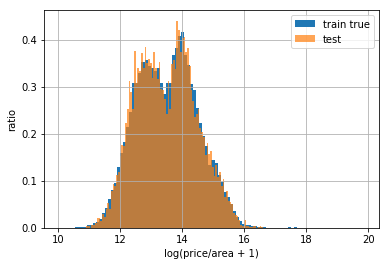

In [23]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

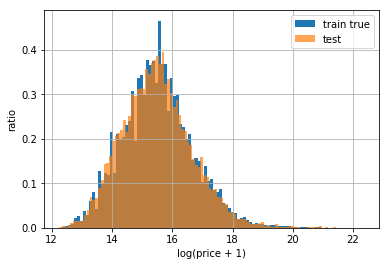

In [24]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

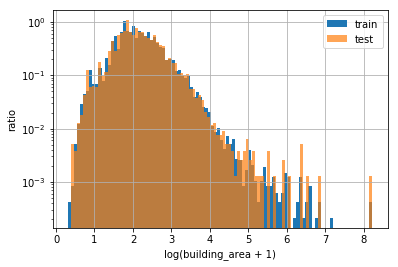

In [25]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

In [ ]:
print([1/17 if i in [3, 4, 5, 7, 8, 12, 13, 14, 16, 17, 19, 20, 22, 23, 24, 25, 26] else 0 \
 for i in range(1,28)])